In [33]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
from sklearn import preprocessing


In [6]:
# Load strain data and parameters
parameter_df = pd.read_csv("Parameters.csv", header=None)
LE_XX = pd.read_csv("LE_XX.csv", header=None)
LE_YY = pd.read_csv("LE_YY.csv", header=None)

# Read in mesh
meshfile = open("V8Template.inp",'r').readlines()
n_lines = len(meshfile)
for i in range(n_lines):
    if meshfile[i][0:5]=="*Node" and '*Node Output' not in meshfile[i] and ('name=SKIN&MUSCLE' in meshfile[i-1]):
        end = 0
        count=0
        node_X_array = []
        node_X_ind = []
        while end<1:
            aux = meshfile[i+count+1].split(',')
            if aux==['CF', ' RF', ' U\n']:
                break
            nodeXi = np.array([float(aux[1]),float(aux[2]),float(aux[3])])
            node_X_array.append(nodeXi)
            node_X_ind.append(int(aux[0]))
            count+=1
            if meshfile[i+count+1][0]=="*":
                end = 1

n_node = count
for i in range(n_lines):
    if meshfile[i][0:5]=="*Elem" and ('type=C3D8H' in meshfile[i]):
        end = 0
        count=0
        elem_array = []
        while end<1:
            aux = meshfile[i+count+1].split(',')
            elemi = np.array([int(aux[1]),int(aux[2]),int(aux[3]),int(aux[4]),int(aux[5]),int(aux[6]),int(aux[7]),int(aux[8])])
            elem_array.append(elemi)
            count+=1
            if meshfile[i+count+1][0]=="*":
                end = 1
        if end==1:
            break

n_elem = count

node_X = np.array(node_X_array)
elements = np.array(elem_array)

In [23]:
# Useful functions
def string_to_list(input_string):
    cleaned_string = input_string.strip('[]')
    numbers_str = cleaned_string.split(',')
    numbers_list = [float(num) for num in numbers_str]
    return numbers_list

def plot_simulation(strain_field, frame):
    tens_place = frame // 10
    ones_place = frame % 10

    fig, ax = plt.subplots()
    ax.set_xlim([-25, 25])
    ax.set_ylim([0, 50])
    ax.set_aspect('equal')
    patches = []
    n_surf_elem = strain_field.shape[0]
    colors = np.zeros((n_surf_elem))
    elemX = np.zeros((n_surf_elem, 2))
    
    # Loop over elements to create patches and assign colors
    for i in range(n_surf_elem):
        n1 = elements[i, 0] - 1
        n2 = elements[i, 1] - 1
        n3 = elements[i, 2] - 1
        n4 = elements[i, 3] - 1
        n1X = np.array([node_X[n1, 0], node_X[n1, 2]])
        n2X = np.array([node_X[n2, 0], node_X[n2, 2]])
        n3X = np.array([node_X[n3, 0], node_X[n3, 2]])
        n4X = np.array([node_X[n4, 0], node_X[n4, 2]])
        elemiX = 0.25 * (n1X + n2X + n3X + n4X)
        elemX[i] = elemiX
        polygon = Polygon([n1X, n2X, n3X, n4X], closed=True)
        patches.append(polygon)
        colors[i] = strain_field[i, frame]
    
    # Set up color normalization based on strain field values
    min_val = np.min(strain_field[:, tens_place * 10 + 9])
    max_val = np.max(strain_field[:, tens_place * 10 + 9])

    norm = Normalize(vmin=min_val, vmax=max_val)

    # Create PatchCollection and add it to the axes
    color_map_name = plt.get_cmap("viridis")
    p = PatchCollection(patches, cmap=color_map_name, norm=norm)
    p.set_array(colors)
    ax.add_collection(p)

    # Remove axis ticks and labels
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label
    
    # Create a divider for the axes to append a horizontal colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)  # Adjust 'size' to control colorbar height
    cbar = fig.colorbar(p, cax=cax, orientation='horizontal')
    cbar.set_label('$LE_{XX}$', fontsize=20)  # Colorbar label font size
    cbar.ax.tick_params(labelsize=20)  # Colorbar tick label font size
    plt.show()

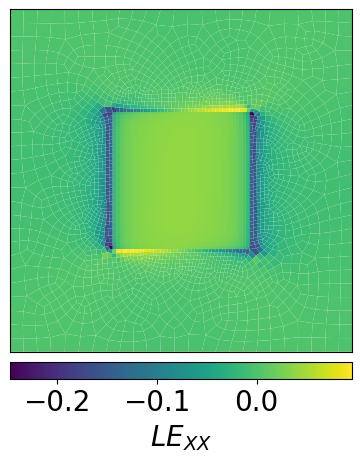

In [ ]:
# Simulation choice
strain_field = np.array(LE_XX)
plot_simulation(strain_field, 16799) # Anything from 0 to 16799

In [30]:
# Load in PCA files
LE_XX_train_targets = pd.read_csv("LE_XX_comps_train.csv", header=None, index_col=0)
LE_XX_test_targets = pd.read_csv("LE_XX_comps_test.csv", header=None, index_col=0)
LE_YY_train_targets = pd.read_csv("LE_YY_comps_train.csv", header=None, index_col=0)
LE_YY_test_targets = pd.read_csv("LE_YY_comps_test.csv", header=None, index_col=0)
train_labels = pd.read_csv("param_train.csv", header=None, index_col=0)
test_labels = pd.read_csv("param_test.csv", header=None, index_col=0)

In [34]:
random.seed(201)

# Define the range and the sample size
range_end = 120
sample_size = 100

# Generate the sample
skin_train_samples = random.sample(range(range_end), sample_size)
skin_train_samples = sorted(skin_train_samples)

# Lets get the other skin parameters indicies
skin_test_samples = [i for i in range(range_end) if i not in skin_train_samples]
skin_test_samples = sorted(skin_test_samples)

experimentwise_parameters = []

for i in range(int(parameter_df.shape[1] / 10)):
    experimentwise_parameters.append(parameter_df.T[i * 10: (i + 1) * 10])

sorted_parameters = []
for i in range(120):
    sorted_parameters.append(experimentwise_parameters[i::120])

param_train_df = [sorted_parameters[train_ind] for train_ind in skin_train_samples]
param_test_df = [sorted_parameters[test_ind] for test_ind in skin_test_samples]

train_indicies = []
test_indicies = []
for skin_set in param_train_df:
    internal = list(pd.concat(skin_set).index)
    train_indicies += internal

for skin_set in param_test_df:
    internal = list(pd.concat(skin_set).index)
    test_indicies += internal

param_train_df = parameter_df.T.loc[train_indicies]
param_test_df = parameter_df.T.loc[test_indicies]

LE_XX_train_df = LE_XX.T.loc[train_indicies]
LE_XX_test_df = LE_XX.T.loc[test_indicies]

LE_YY_train_df = LE_YY.T.loc[train_indicies]
LE_YY_test_df = LE_YY.T.loc[test_indicies]

LE_XX_scalar = preprocessing.StandardScaler()
LE_YY_scalar = preprocessing.StandardScaler()

LE_XX_scaled = LE_XX_scalar.fit_transform(LE_XX_train_df)
LE_YY_scaled = LE_YY_scalar.fit_transform(LE_YY_train_df)
LE_XX_test_scaled = LE_XX_scalar.transform(LE_XX_test_df)
LE_YY_test_scaled = LE_YY_scalar.transform(LE_YY_test_df)

pca_LE_XX = PCA(n_components=8, svd_solver="randomized") # n_components=8
pca_LE_YY = PCA(n_components=8, svd_solver="randomized") # n_components=8
pca_LE_XX.fit(LE_XX_scaled)
pca_LE_YY.fit(LE_YY_scaled)

LE_XX_comps_train = pca_LE_XX.transform(LE_XX_scaled)
LE_YY_comps_train = pca_LE_YY.transform(LE_YY_scaled)
LE_XX_comps_test = pca_LE_XX.transform(LE_XX_test_scaled)
LE_YY_comps_test = pca_LE_YY.transform(LE_YY_test_scaled)

0.9942614448538135
0.9940281331948801


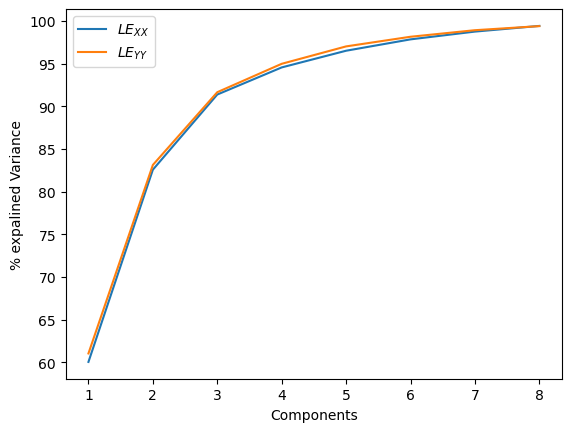

In [35]:
# PCA explained variance

x = range(0,8)
LE_XX_cvr = np.cumsum(pca_LE_XX.explained_variance_ratio_)
LE_YY_cvr = np.cumsum(pca_LE_YY.explained_variance_ratio_)

print(LE_XX_cvr[7])
print(LE_YY_cvr[7])
plt.plot(np.array(x)+1, LE_XX_cvr[x] * 100, label="$LE_{XX}$")
plt.plot(np.array(x)+1, LE_YY_cvr[x] * 100, label="$LE_{YY}$")
plt.ylabel("% expalined Variance")
plt.xlabel("Components")
plt.ylabel("% expalined Variance")
plt.legend()

In [36]:
# PCA Plotting
def plot_component(strain, comp, save_path):
    fig, ax = plt.subplots()
    
    ax.set_xlim([-25, 25])
    ax.set_ylim([0, 50])
    ax.set_aspect('equal')
    
    # Remove x and y ticks, but keep the axis outline (black outline)
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks

    patches = []
    viridis = matplotlib.cm.get_cmap('viridis', 50)
    n_surf_elem = strain.shape[1]
    colors = np.zeros((n_surf_elem))
    elemX = np.zeros((n_surf_elem, 2))

    for i in range(n_surf_elem):
        n1 = elements[i, 0] - 1
        n2 = elements[i, 1] - 1
        n3 = elements[i, 2] - 1
        n4 = elements[i, 3] - 1
        
        n1X = np.array([node_X[n1, 0], node_X[n1, 2]])
        n2X = np.array([node_X[n2, 0], node_X[n2, 2]])
        n3X = np.array([node_X[n3, 0], node_X[n3, 2]])
        n4X = np.array([node_X[n4, 0], node_X[n4, 2]])
        elemiX = 0.25 * (n1X + n2X + n3X + n4X)
        elemX[i] = elemiX
        
        polygon = Polygon([n1X, n2X, n3X, n4X], closed=True)
        patches.append(polygon)
        colors[i] = strain[comp, i]

    color_map_name = plt.colormaps["viridis"]
    p = PatchCollection(patches, cmap=color_map_name)
    p.set_array(colors)
    ax.add_collection(p)

    # Adjust plot margins
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Save the figure with a transparent background
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)

    plt.close()  # Close the plot after saving to free up memory

# Loop through all components and save each plot
def save_all_components(strain):
    num_components = strain.shape[0]  # Assuming strain has components in the first dimension
    for comp in range(num_components):
        file_name = f'component_{comp}_plot.png'
        plot_component(strain, comp, file_name)
        print(f'Saved: {file_name}')

# Usage example
components = pca_LE_XX.components_
# save_all_components(components)


/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_75286/2056929699.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = matplotlib.cm.get_cmap('viridis', 50)


Saved: component_0_plot.png
Saved: component_1_plot.png
Saved: component_2_plot.png
Saved: component_3_plot.png
Saved: component_4_plot.png
Saved: component_5_plot.png
Saved: component_6_plot.png
Saved: component_7_plot.png
